In [1]:
# default
from pprint import pprint
import natsort
import os
import pickle as pkl

# data structure
import numpy as np
from PIL import Image

# visualize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from torchvision import transforms
from torchvision import models
from torchvision.models import resnet50
from torchvision.models import efficientnet_v2_s, efficientnet_v2_m, efficientnet_v2_l

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import module.image_preprocessing as ipp
import module.skin_disease_model as sdm
from module.data_processing import mkadir

TRAIN = 0
VALID = 1
data_type = ["train", "valid"]
dt = data_type[TRAIN]

project_path = "E:/Tukorea/Capstone/"
original_data_path = os.path.join(project_path, "dataset/", "original/", f"{dt}/")
RoI_data_path = os.path.join(project_path, "dataset/", "RoI/", f"{dt}/")
background_RoI_data_path = os.path.join(project_path, "dataset/", "background_RoI/", f"{dt}/")
box_data_path = os.path.join(project_path, "dataset/", "box/256x256/", f"{dt}/")
crop_data_path = os.path.join(project_path, "dataset/", "crop/", f"{dt}/")
RZ_data_path = os.path.join(project_path, "dataset/", "ratio_zero-padding/", f"{dt}/")
RZ_LANCZOS4_data_path = os.path.join(project_path, "dataset/", "RZ_LANCZOS4/", f"{dt}/")

data_path_namelist = ["original", "RoI", "background_RoI", "box", "crop", "ratio_zero-padding", "RZ_LANCZOS4"]
data_path_list = [original_data_path, RoI_data_path, background_RoI_data_path, box_data_path, crop_data_path, RZ_data_path, RZ_LANCZOS4_data_path]

print("DATA TYPE:", dt, end="\n\n")
for i, data_path in enumerate(data_path_list):
    print(data_path_namelist[i] + " data folder")
    folder = natsort.natsorted(os.listdir(data_path))
    print(folder, end="\n\n")

DATA TYPE: train

original data folder
['A1', 'A2', 'A3', 'A4', 'A5']

RoI data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

background_RoI data folder
['A1', 'A2', 'A3', 'A4', 'A5']

box data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

crop data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

ratio_zero-padding data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

RZ_LANCZOS4 data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']



---
# Scenario 1

In [3]:
dataset_path = "/".join(RZ_LANCZOS4_data_path.split("/")[:-1]) + "/"

# 이미지 불러오기
with open(os.path.join(dataset_path, "224x224_train_data.pkl"), "rb") as pkl_file:
  train_x, train_y = pkl.load(pkl_file)

with open(os.path.join(dataset_path, "224x224_valid_data.pkl"), "rb") as pkl_file:
  valid_x, valid_y = pkl.load(pkl_file)

print("train_x length: ", len(train_x))
print("train_x type: ", type(train_x))
print("train_y length: ", train_y.shape)
print("train_y type: ", type(train_y))
print("valid_x length: ", len(valid_x))
print("valid_x type: ", type(valid_x))
print("valid_y length: ", valid_y.shape)
print("valid_y type: ", type(valid_y))

train_x length:  53430
train_x type:  <class 'list'>
train_y length:  (53430,)
train_y type:  <class 'numpy.ndarray'>
valid_x length:  6645
valid_x type:  <class 'list'>
valid_y length:  (6645,)
valid_y type:  <class 'numpy.ndarray'>


---
# Scenario 2 (Class 분할)

In [ ]:
# y를 통해서 입력된 숫자대로 클래스를 나누어 리스트로 반환한다.
def split_label(x, y, label_num):
    u, c = np.unique(y, return_counts=True)

    labels = list()
    
    prev_loc = 0
    end_loc = 0
    for i, loc in enumerate(c):
        end_loc += loc

        if (i + 1) % label_num == 0:
            labels.append((x[prev_loc:end_loc].copy(), y[prev_loc:end_loc].copy()))
            prev_loc = end_loc

    if prev_loc != end_loc:
        labels.append((x[prev_loc:end_loc].copy(), y[prev_loc:end_loc].copy()))

    return labels

In [ ]:
sltrain = split_label(train_x, train_y, 3)
slvalid = split_label(valid_x, valid_y, 3)

In [ ]:
DATA = 0
LABEL = 1
ORDER = 0

split_train_x = sltrain[ORDER][DATA]
split_train_y = sltrain[ORDER][LABEL]
split_valid_x = slvalid[ORDER][DATA]
split_valid_y = slvalid[ORDER][LABEL]

tu, tc = np.unique(split_train_y, return_counts=True)
vu, vc = np.unique(split_valid_y, return_counts=True)

print(tu, tc)
print(vu, vc)

[0 1 2] [ 8730 10762 10539]
[0 1 2] [1087 1331 1317]


In [ ]:
split_train_y[split_train_y == 3] = 0
split_train_y[split_train_y == 4] = 1
split_train_y[split_train_y == 5] = 2

In [ ]:
split_valid_y[split_valid_y == 3] = 0
split_valid_y[split_valid_y == 4] = 1
split_valid_y[split_valid_y == 5] = 2

In [ ]:
print(np.unique(split_train_y))
print(np.unique(split_valid_y))

[0 1 2]
[0 1 2]


In [ ]:
del train_x, valid_x, train_y, valid_y
del sltrain, slvalid

---
# Scenario 3 (보간법)

In [4]:
# fname = "10-130"
# dataset_path = "/".join(RZ_LANCZOS4_data_path.split("/")[:-1]) + f"/{fname}/"
# fname = "131-391"
# dataset_path = "/".join(RZ_LANCZOS4_data_path.split("/")[:-1]) + "/131-391/"
fname = "392-"
dataset_path = "/".join(RZ_LANCZOS4_data_path.split("/")[:-1]) + "/392-/"

In [5]:
# 이미지 불러오기
with open(os.path.join(dataset_path, f"{fname}_train_data.pkl"), "rb") as pkl_file:
  train_x, train_y = pkl.load(pkl_file)

with open(os.path.join(dataset_path, f"{fname}_valid_data.pkl"), "rb") as pkl_file:
  valid_x, valid_y = pkl.load(pkl_file)

print("train_x length: ", len(train_x))
print("train_x type: ", type(train_x))
print("train_y length: ", train_y.shape)
print("train_y type: ", type(train_y))
print("valid_x length: ", len(valid_x))
print("valid_x type: ", type(valid_x))
print("valid_y length: ", valid_y.shape)
print("valid_y type: ", type(valid_y))

train_x length:  6380
train_x type:  <class 'list'>
train_y length:  (6380,)
train_y type:  <class 'numpy.ndarray'>
valid_x length:  950
valid_x type:  <class 'list'>
valid_y length:  (950,)
valid_y type:  <class 'numpy.ndarray'>


---
# Scenario 4 (Multi-scaling + Data Augmenation)

In [ ]:
# Load Train Data
csv_data_path = os.path.join(project_path, "dataset/", "csv_file/", f"{dt}/")
print(csv_data_path)

csv_data = None
for i, csv_file in enumerate(natsort.natsorted(os.listdir(csv_data_path))):
    temp_csv = pd.read_csv(csv_data_path + csv_file)
    temp_csv["Y"] = i
    if (isinstance(csv_data, type(None))): csv_data = temp_csv
    else:                                  csv_data = pd.concat([csv_data, temp_csv], ignore_index=True)
    
# exist가 Y인 행만 가져온다. (= 이미지가 존재하는 행만 가져온다.)
csv_data = csv_data.loc[csv_data["exist"] == "Y"]

# 관심영역의 높이와 폭이 10보다 작다면 제거한다.
csv_data = ipp.get_RoI_range_csv(1920, csv_data)

# lesions error 잡기
csv_data["lesions"].loc[csv_data["lesions"] == " A5"] = "A5"

# y 불러오기
train_y = np.array(csv_data["Y"])

In [3]:
# Load Validation Data
dataset_path = "/".join(background_RoI_data_path.split("/")[:-2]) + "/"

# 이미지 불러오기
valid_x_list = list()
valid_y_list = list()
for dir in natsort.natsorted(os.listdir(dataset_path)):
    if ".pkl" in dir:
        with open(os.path.join(dataset_path, dir), "rb") as pkl_file:
            valid_x, valid_y = pkl.load(pkl_file)
        valid_x_list.append(valid_x)
        valid_y_list.append(valid_y)

        print(f"[{dir}]")
        print("valid_x length: ", len(valid_x))
        print("valid_x type: ", type(valid_x))
        print("valid_y length: ", valid_y.shape)
        print("valid_y type: ", type(valid_y), end="\n\n")

[valid_60p.pkl]
valid_x length:  6645
valid_x type:  <class 'list'>
valid_y length:  (6645,)
valid_y type:  <class 'numpy.ndarray'>

[valid_70p.pkl]
valid_x length:  6645
valid_x type:  <class 'list'>
valid_y length:  (6645,)
valid_y type:  <class 'numpy.ndarray'>

[valid_80p.pkl]
valid_x length:  6645
valid_x type:  <class 'list'>
valid_y length:  (6645,)
valid_y type:  <class 'numpy.ndarray'>

[valid_90p.pkl]
valid_x length:  6645
valid_x type:  <class 'list'>
valid_y length:  (6645,)
valid_y type:  <class 'numpy.ndarray'>



---
# Scenario 5 (Multi-scaling + Data Augumentaion) ver. 2

In [ ]:
# Load Train Data
csv_data_path = os.path.join(project_path, "dataset/", "csv_file/", f"{dt}/")
print(csv_data_path)

csv_data = None
for i, csv_file in enumerate(natsort.natsorted(os.listdir(csv_data_path))):
    temp_csv = pd.read_csv(csv_data_path + csv_file)
    temp_csv["Y"] = i
    if (isinstance(csv_data, type(None))): csv_data = temp_csv
    else:                                  csv_data = pd.concat([csv_data, temp_csv], ignore_index=True)
    
# exist가 Y인 행만 가져온다. (= 이미지가 존재하는 행만 가져온다.)
csv_data = csv_data.loc[csv_data["exist"] == "Y"]

# 관심영역의 높이와 폭이 10보다 작다면 제거한다.
csv_data = ipp.get_RoI_range_csv(1920, csv_data)

# lesions error 잡기
csv_data["lesions"].loc[csv_data["lesions"] == " A5"] = "A5"

In [3]:
csv_data.drop(axis=0, index=csv_data.loc[csv_data["Y"] == 1].index, inplace=True)
csv_data.loc[csv_data.loc[csv_data["Y"] == 2].index, "Y"] = 1
csv_data.loc[csv_data.loc[csv_data["Y"] == 3].index, "Y"] = 2
csv_data.loc[csv_data.loc[csv_data["Y"] == 4].index, "Y"] = 3
csv_data.loc[csv_data.loc[csv_data["Y"] == 5].index, "Y"] = 4

# y 불러오기
train_y = np.array(csv_data["Y"])

In [4]:
# Load Validation Data
dataset_path = "/".join(background_RoI_data_path.split("/")[:-2]) + "/"

# 이미지 불러오기
valid_x_list = list()
valid_y_list = list()
for dir in natsort.natsorted(os.listdir(dataset_path)):
    if ".pkl" in dir:
        with open(os.path.join(dataset_path, dir), "rb") as pkl_file:
            valid_x, valid_y = pkl.load(pkl_file)
        valid_x_list.append(valid_x)
        valid_y_list.append(valid_y)

        print(f"[{dir}]")
        print("valid_x length: ", len(valid_x))
        print("valid_x type: ", type(valid_x))
        print("valid_y length: ", valid_y.shape)
        print("valid_y type: ", type(valid_y), end="\n\n")

[valid_40p.pkl]
valid_x length:  5314
valid_x type:  <class 'list'>
valid_y length:  (5314,)
valid_y type:  <class 'numpy.ndarray'>

[valid_50p.pkl]
valid_x length:  5314
valid_x type:  <class 'list'>
valid_y length:  (5314,)
valid_y type:  <class 'numpy.ndarray'>

[valid_60p.pkl]
valid_x length:  5314
valid_x type:  <class 'list'>
valid_y length:  (5314,)
valid_y type:  <class 'numpy.ndarray'>

[valid_70p.pkl]
valid_x length:  5314
valid_x type:  <class 'list'>
valid_y length:  (5314,)
valid_y type:  <class 'numpy.ndarray'>

[valid_80p.pkl]
valid_x length:  5314
valid_x type:  <class 'list'>
valid_y length:  (5314,)
valid_y type:  <class 'numpy.ndarray'>



---
# DeepLearning with PyTorch

---
## Scenario 1 ~ 3 Transforms and dataset

In [38]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
train_dataset = sdm.Skin_Disease_Dataset(train_x, train_y, train_transforms)
valid_dataset = sdm.Skin_Disease_Dataset(valid_x, valid_y, test_transforms)
train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

---
## Scenario 4 Transforms

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
train_dataset = sdm.Skin_Disease_Dataset2(csv_data, train_y, train_transforms, original_data_path)
valid_dataset = sdm.Skin_Disease_Dataset(valid_x_list, valid_y_list, test_transforms)
train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

---
## Scenario 5 Transforms

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train_dataset = sdm.Skin_Disease_Dataset3(csv_data, train_y, train_transforms, original_data_path)
valid_dataset = sdm.Skin_Disease_Dataset(valid_x_list, valid_y_list, test_transforms)
train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

# Model

In [8]:
model_path = os.path.join(project_path, "model/", "2023-06-21/")
mkadir(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = sdm.Skin_Distinction_Model(model=efficientnet_v2_s(weights="DEFAULT"),
                                   out_features=5,
                                   device=device,
                                   save_path=model_path).to(device)

pprint(summary(model, input_size=(1, 3, 224, 224), verbose=0))

Layer (type:depth-idx)                                       Output Shape              Param #
Skin_Distinction_Model                                       [1, 5]                    --
├─EfficientNet: 1-1                                          [1, 1000]                 --
│    └─Sequential: 2-1                                       [1, 1280, 7, 7]           --
│    │    └─Conv2dNormActivation: 3-1                        [1, 24, 112, 112]         696
│    │    └─Sequential: 3-2                                  [1, 24, 112, 112]         10,464
│    │    └─Sequential: 3-3                                  [1, 48, 56, 56]           303,552
│    │    └─Sequential: 3-4                                  [1, 64, 28, 28]           589,184
│    │    └─Sequential: 3-5                                  [1, 128, 14, 14]          917,680
│    │    └─Sequential: 3-6                                  [1, 160, 14, 14]          3,463,840
│    │    └─Sequential: 3-7                                  [1, 256

In [9]:
# 0.000213388
# optimizer = optim.SGD(model.parameters(), lr=7.5e-7, momentum=0.999, weight_decay=1e-5, nesterov=True)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 50

In [10]:
print(device)
parameters = {
    'Train_DataLoader' : train_data_loader,
    'Valid_DataLoader' : valid_data_loader,
    'Optimizer'        : optimizer,
    'Loss_function'    : criterion,
    'Epochs'           : epochs
}

cuda


In [11]:
model_path

'E:/Tukorea/Capstone/model/2023-06-21/'

In [12]:
# Load model
model.load_state_dict(torch.load(os.path.join("E:/Tukorea/Capstone/model/2023-06-20/", "last_learning.pth")))

<All keys matched successfully>

In [ ]:
history = model.fit(parameters)

# Evaluate

In [10]:
print("Now model path:", model_path)

Now model path: E:/Tukorea/Capstone/model/2023-06-20/


In [11]:
# Load history -1
with open(os.path.join("E:/Tukorea/Capstone/model/2023-05-17/", "last_history.pkl"), "rb") as pkl_file:
    history1 = pkl.load(pkl_file)

In [12]:
# Load history -2
with open(os.path.join(model_path, "last_history.pkl"), "rb") as pkl_file:
    history2 = pkl.load(pkl_file)

# Load model
model.load_state_dict(torch.load(os.path.join(model_path, "high_acc.pth")))

<All keys matched successfully>

In [14]:
history = dict()
history["train_acc"] = history1["train_acc"] + history2["train_acc"]
history["train_loss"] = history1["train_loss"] + history2["train_loss"]
history["valid_acc"] = history1["valid_acc"] + history2["valid_acc"]
history["valid_loss"] = history1["valid_loss"] + history2["valid_loss"]

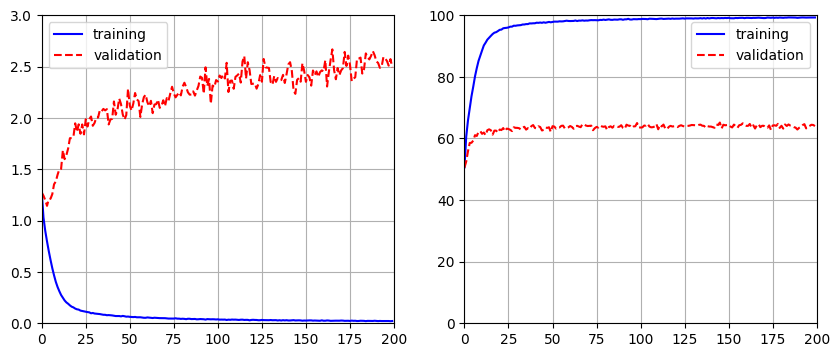

In [15]:
from math import ceil

train_loss = history["train_loss"]
train_acc = history["train_acc"]
valid_loss = history["valid_loss"]
valid_acc = history["valid_acc"]
epoch = len(history["train_loss"])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_loss, 'b', label="training")
ax[0].plot(valid_loss, '--r', label="validation")
ax[0].set_xlim((0, epoch))
max_y = ceil(max(valid_loss)) if max(train_loss) < max(valid_loss) else ceil(max(train_loss))
ax[0].set_ylim((0, max_y))
ax[0].legend()
ax[0].grid()

ax[1].plot(train_acc, 'b', label="training")
ax[1].plot(valid_acc, '--r', label="validation")
ax[1].set_xlim((0, epoch))
ax[1].set_ylim((0, 100))
ax[1].legend()
ax[1].grid()
plt.show()

In [60]:
# Scenario 4: 2023-05-21
PERCENT10 = -1
PERCENT20 = -1
PERCENT30 = -1
PERCENT40 = -1
PERCENT50 = -1
PERCENT60 = 0
PERCENT70 = 1
PERCENT80 = 2
PERCENT90 = 3

valid_x, valid_y = valid_x_list[PERCENT90], valid_y_list[PERCENT90]

In [61]:
# 예측할 때 사용됨
def shuffle_data(x, y, seed):
    if len(x) != len(y):
        print("x and y are not same the length.")
        return

    order = np.arange(len(y))
    np.random.seed(seed)
    np.random.shuffle(order)
    
    new_x = list()
    for i in order:
        new_x.append(x[i])
    
    return new_x, y[order], order

In [62]:
# train_x, train_y, order = shuffle_data(train_x, train_y, 42)
# valid_x, valid_y, order = shuffle_data(valid_x, valid_y, 42)
split_valid_x, split_valid_y, order = shuffle_data(valid_x, valid_y, 42)

In [ ]:
with torch.no_grad():
    pred, labels = model.predict(valid_x, test_transforms)

In [64]:
accuracy_score(y_true=valid_y, y_pred=labels.cpu())

0.6386756960120391

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# 예측값과 레이블 값을 가져옵니다.
out_features = 6
y_pred = pred.cpu()
y_true = valid_y

# Softmax 함수를 사용하여 확률값을 계산합니다.
y_pred = torch.softmax(y_pred, dim=1)

# 각 클래스에 대한 AUC 값을 계산합니다.
auc_list = []
for i in range(out_features):
    auc = roc_auc_score((y_true == i), y_pred[:, i].numpy())
    auc_list.append(auc)

# AUC 값을 출력합니다.
print("AUC per class:", auc_list)

# 각 클래스별 FPR과 TPR 값을 구합니다.
fpr_list = []
tpr_list = []
for i in range(out_features):
    fpr, tpr, _ = roc_curve((y_true == i), y_pred[:, i].numpy())
    fpr_list.append(fpr)
    tpr_list.append(tpr)

# 모든 클래스에 대한 FPR과 TPR 값을 평균 내어 멀티클래스 AUC 값을 구합니다.
mean_fpr = np.unique(np.concatenate(fpr_list))
mean_tpr = np.zeros_like(mean_fpr)
for i in range(out_features):
    mean_tpr += np.interp(mean_fpr, fpr_list[i], tpr_list[i])
mean_tpr /= out_features

# 멀티클래스 AUC-ROC 커브를 그립니다.
plt.plot(mean_fpr, mean_tpr, label='Multi-class ROC curve (AUC = %0.2f)' % np.mean(auc_list))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=valid_y, y_pred=labels.cpu(), target_names=["A1", "A2", "A3", "A4", "A5", "A6"]))